## Closely follow 1023_method1_via_yasin.ipynb

### Imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Import necessary modules from dicomviewer
sys.path.append('/homebase/DL_projects/code_sync/myMedIADIRLab/third_party/dicomviewer/src')
from dicom_viewer.readers.RTStructReader import RTStructReader
from dicom_viewer.readers.DICOMImageReader import DICOMImageReader



In [2]:
# Define the path to the RT struct file
image_path     = "/database/brainmets/dicom/Data/SRS0871/1999-04__Studies/SRS0871_SRS0871_MR_1999-04-02_000000_._axial1_n47__00000"
rt_struct_path = "/database/brainmets/dicom/Data/SRS0871/1999-04__Studies/SRS0871_SRS0871_RTst_1999-04-02_000000_._Brain.MS.ReTx.Model_n1__00000"

# read dicom file
if os.path.exists(image_path):
    print(f"Dicom path exists: {image_path}")
    image_reader = DICOMImageReader(image_path, modality="MR")
    image_reader.read()
    print("Dicom file loaded successfully!")
else:
    print(f"Path does not exist: {image_path}")

# read rt struct file
if os.path.exists(rt_struct_path):
    print(f"RT struct path exists: {rt_struct_path}")
    
    # Initialize and load the RT struct reader
    rt_reader = RTStructReader(rt_struct_path)
    rt_reader.read()
    
    print("RT struct file loaded successfully!")
else:
    print(f"Path does not exist: {rt_struct_path}")


Dicom path exists: /database/brainmets/dicom/Data/SRS0871/1999-04__Studies/SRS0871_SRS0871_MR_1999-04-02_000000_._axial1_n47__00000
Dicom file loaded successfully!
RT struct path exists: /database/brainmets/dicom/Data/SRS0871/1999-04__Studies/SRS0871_SRS0871_RTst_1999-04-02_000000_._Brain.MS.ReTx.Model_n1__00000
RT struct file loaded successfully!


In [3]:
### Overview the structures
structure_names = rt_reader.get_structure_names()
print(f"Found {len(structure_names)} structures:")
for i, name in enumerate(structure_names):
    print(f"{i+1}. {name}")
## Which structure do I want to inspect
structure_name = "target1"
structure_index = rt_reader.get_structure_index(structure_name)

print(f"structure_name: {structure_name}, structure_index: {structure_index}")

contour_data = rt_reader.roi_contours[structure_index]

Found 5 structures:
1. target1
2. *Skull
3. 12.00 Gy (35.60% of dose)
4. Brain_target1
5. Brain-target1
structure_name: target1, structure_index: 0


In [4]:
print(contour_data)

(3006,002A) ROI Display Color                   IS: [255, 0, 0]
(3006,0040)  Contour Sequence  9 item(s) ---- 
   (3006,0016)  Contour Image Sequence  1 item(s) ---- 
      (0008,1150) Referenced SOP Class UID            UI: Secondary Capture Image Storage
      (0008,1155) Referenced SOP Instance UID         UI: 2.16.840.1.114362.1.12046989.25631758973.631597875.835.2172
      ---------
   (3006,0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006,0046) Number of Contour Points            IS: '26'
   (3006,0050) Contour Data                        DS: Array of 78 elements
   ---------
   (3006,0016)  Contour Image Sequence  1 item(s) ---- 
      (0008,1150) Referenced SOP Class UID            UI: Secondary Capture Image Storage
      (0008,1155) Referenced SOP Instance UID         UI: 2.16.840.1.114362.1.12046989.25631758973.631597875.836.2173
      ---------
   (3006,0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006,0046) Number of Contour Point

# Debug the original rasterizing code

In [5]:
mask_default = rt_reader.get_structure_mask(structure_name, image_reader)

print(mask_default.dtype, mask_default.shape)
print(np.min(mask_default), np.max(mask_default))

uint8 (47, 256, 256)
0 1


In [6]:
import SimpleITK as sitk
ct_array_shape = sitk.GetArrayFromImage(image_reader.image).shape  # (z, y, x)
print(ct_array_shape) # (47, 256, 256)
mask = np.zeros(ct_array_shape, dtype=np.uint8)

(47, 256, 256)


In [7]:
for ci, contour in enumerate(contour_data.ContourSequence):
    contour_points = np.array(contour.ContourData).reshape(-1, 3)  # (x, y, z) in mm
    print(contour_points.shape)

    print(contour_points)

    break

(26, 3)
[[115.67  147.67  -11.95 ]
 [115.964 147.377 -11.95 ]
 [118.312 147.377 -11.95 ]
 [118.606 147.67  -11.95 ]
 [118.9   147.964 -11.95 ]
 [119.193 148.258 -11.95 ]
 [119.487 148.551 -11.95 ]
 [119.78  148.845 -11.95 ]
 [119.78  150.606 -11.95 ]
 [119.487 150.9   -11.95 ]
 [119.193 151.193 -11.95 ]
 [118.9   151.487 -11.95 ]
 [118.606 151.78  -11.95 ]
 [118.312 152.074 -11.95 ]
 [116.551 152.074 -11.95 ]
 [116.257 151.78  -11.95 ]
 [115.964 151.487 -11.95 ]
 [115.377 151.487 -11.95 ]
 [115.083 151.193 -11.95 ]
 [115.083 150.606 -11.95 ]
 [114.789 150.313 -11.95 ]
 [114.496 150.019 -11.95 ]
 [114.496 148.845 -11.95 ]
 [114.789 148.551 -11.95 ]
 [115.083 148.258 -11.95 ]
 [115.377 147.964 -11.95 ]]


In [8]:
for ci, contour in enumerate(contour_data.ContourSequence):
    contour_points = np.array(contour.ContourData).reshape(-1, 3)  # (x, y, z) in mm
    print(f"Contour {ci}: {contour_points.shape[0]} points")
    print(f"Contour points shape: {contour_points.shape}")
    print(f"\nContour points:\n{contour_points}")

    # Compute distances between adjacent points
    num_points = contour_points.shape[0]
    distances = np.zeros(num_points)
    
    # Compute distances: 1-2, 2-3, ..., (n-1)-n
    for i in range(num_points - 1):
        distances[i] = np.linalg.norm(contour_points[i+1] - contour_points[i])
    
    # Compute distance from last point to first point (wrapping): n-1
    distances[num_points - 1] = np.linalg.norm(contour_points[0] - contour_points[num_points - 1])
    
    print(f"\nDistances between adjacent points (in mm):")
    print(f"Total number of distances: {len(distances)}")
    for i in range(num_points):
        if i < num_points - 1:
            print(f"  Point {i+1} to {i+2}: {distances[i]:.4f} mm")
        else:
            print(f"  Point {i+1} to 1 (wrapping): {distances[i]:.4f} mm")
    
    print(f"\nDistance statistics:")
    print(f"  Min distance: {np.min(distances):.4f} mm")
    print(f"  Max distance: {np.max(distances):.4f} mm")
    print(f"  Mean distance: {np.mean(distances):.4f} mm")
    print(f"  Std distance: {np.std(distances):.4f} mm")
    print(f"\nDistance array: {distances}")

    break

Contour 0: 26 points
Contour points shape: (26, 3)

Contour points:
[[115.67  147.67  -11.95 ]
 [115.964 147.377 -11.95 ]
 [118.312 147.377 -11.95 ]
 [118.606 147.67  -11.95 ]
 [118.9   147.964 -11.95 ]
 [119.193 148.258 -11.95 ]
 [119.487 148.551 -11.95 ]
 [119.78  148.845 -11.95 ]
 [119.78  150.606 -11.95 ]
 [119.487 150.9   -11.95 ]
 [119.193 151.193 -11.95 ]
 [118.9   151.487 -11.95 ]
 [118.606 151.78  -11.95 ]
 [118.312 152.074 -11.95 ]
 [116.551 152.074 -11.95 ]
 [116.257 151.78  -11.95 ]
 [115.964 151.487 -11.95 ]
 [115.377 151.487 -11.95 ]
 [115.083 151.193 -11.95 ]
 [115.083 150.606 -11.95 ]
 [114.789 150.313 -11.95 ]
 [114.496 150.019 -11.95 ]
 [114.496 148.845 -11.95 ]
 [114.789 148.551 -11.95 ]
 [115.083 148.258 -11.95 ]
 [115.377 147.964 -11.95 ]]

Distances between adjacent points (in mm):
Total number of distances: 26
  Point 1 to 2: 0.4151 mm
  Point 2 to 3: 2.3480 mm
  Point 3 to 4: 0.4151 mm
  Point 4 to 5: 0.4158 mm
  Point 5 to 6: 0.4151 mm
  Point 6 to 7: 0.4151 mm

In [9]:

from skimage.draw import polygon2mask

verbose = True


slc_cnt = 0

# --- 1) Convert each contour to index space and group by slice --- #
for ci, contour in enumerate(contour_data.ContourSequence):
    contour_points = np.array(contour.ContourData).reshape(-1, 3)  # (x, y, z) in mm

    # Transform physical coordinates to voxel indices for this image
    indices = np.array(
        [image_reader.image.TransformPhysicalPointToIndex(tuple(pt)) for pt in contour_points]
    )  # (N, 3) in (i, j, k) ~ (x, y, z indices)

    # Swap x & y so indices[:,0] = row (y), indices[:,1] = col (x)
    indices[:, [1, 0]] = indices[:, [0, 1]]

    # All points for this contour should lie on the same slice (same k index)
    slice_index = np.unique(indices[:, 2])
    if len(slice_index) != 1:
        raise ValueError("Contour points do not lie on a single slice")
    slice_index = int(slice_index[0])


    # Convert indices to 2D for the slice
    points_2d = indices[:, :2]

    # Create a boolean mask for the contour
    slice_shape = mask[slice_index].shape
    slice_mask = polygon2mask(slice_shape, points_2d)

    print(f"ci: {ci}, slice_index: {slice_index}, np.sum(slice_mask): {np.sum(slice_mask)}")

    slc_cnt += np.sum(slice_mask)


    # plt.figure()
    # plt.imshow(slice_mask)
    # plt.title(str(slice_index))

    # Update the mask array with this slice mask
    mask[slice_index] = np.maximum(mask[slice_index], slice_mask.astype(np.uint8))

ci: 0, slice_index: 42, np.sum(slice_mask): 20
ci: 1, slice_index: 41, np.sum(slice_mask): 91
ci: 2, slice_index: 40, np.sum(slice_mask): 194
ci: 3, slice_index: 39, np.sum(slice_mask): 174
ci: 4, slice_index: 39, np.sum(slice_mask): 44
ci: 5, slice_index: 38, np.sum(slice_mask): 161
ci: 6, slice_index: 38, np.sum(slice_mask): 33
ci: 7, slice_index: 37, np.sum(slice_mask): 117
ci: 8, slice_index: 36, np.sum(slice_mask): 54


In [10]:
print(slc_cnt)
print(np.sum(mask))

888
886


(47, 256, 256)


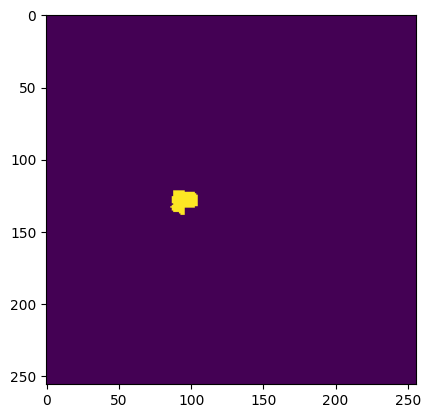

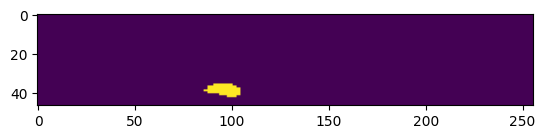

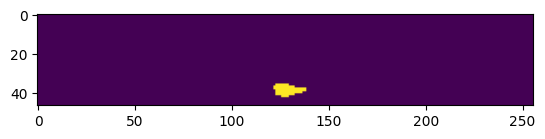

In [11]:
print(mask.shape)

plt.figure()
plt.imshow(np.max(mask, axis=0))

plt.figure()
plt.imshow(np.max(mask, axis=1))

plt.figure()
plt.imshow(np.max(mask, axis=2))

36
37
38
39
40
41
42


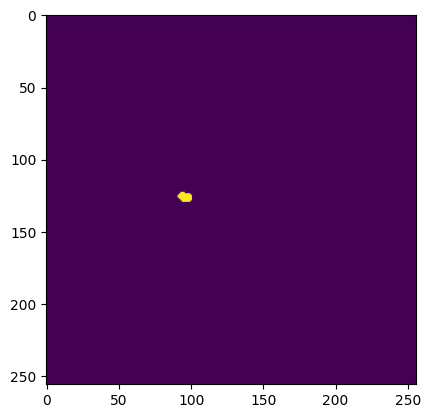

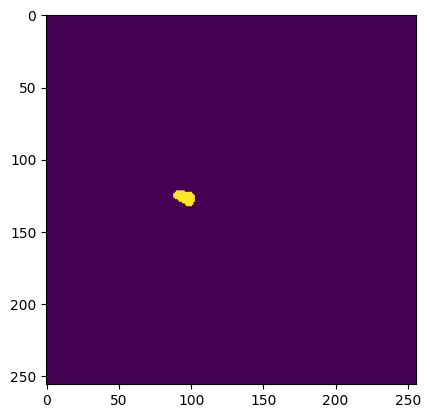

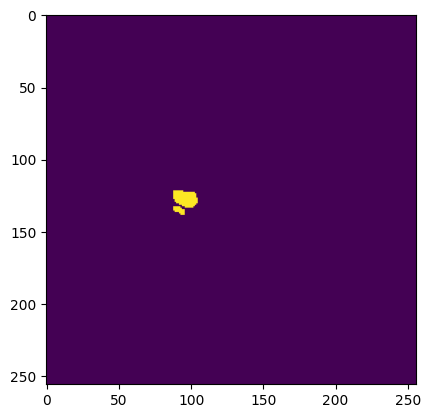

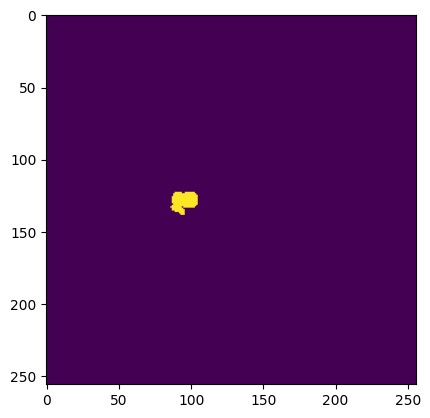

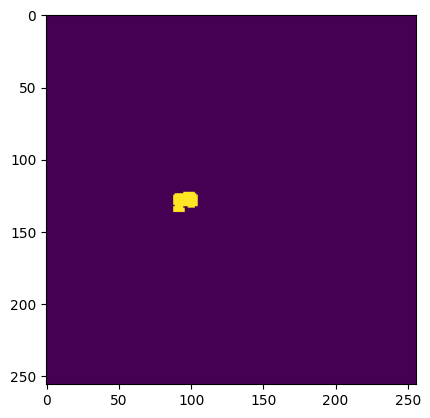

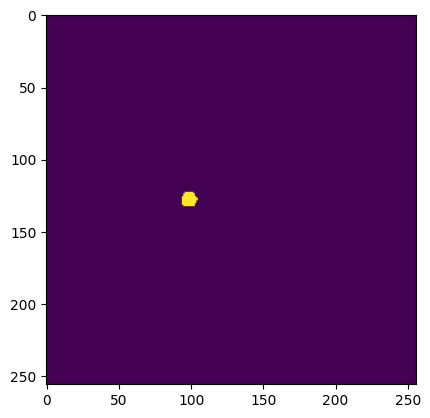

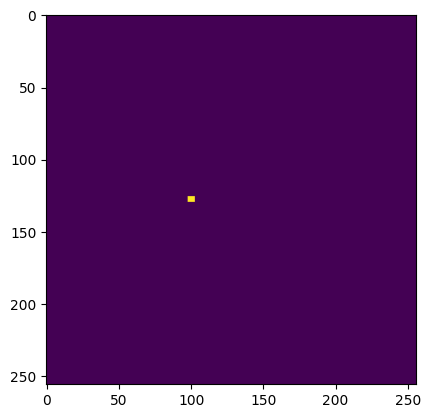

In [12]:
for slc_idx in range(36, 42+1):
    print(slc_idx)
    plt.figure()
    plt.imshow(mask[slc_idx,:,:])

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.draw import polygon2mask

# ==========================================
# 1. Define High-Resolution Grid Geometry
# ==========================================

# Target isotropic resolution
target_spacing = (0.5, 0.5, 0.5)

# Get Original Image properties
orig_image = image_reader.image
orig_size = np.array(orig_image.GetSize())       # (x, y, z)
orig_spacing = np.array(orig_image.GetSpacing()) # (x, y, z)
orig_origin = orig_image.GetOrigin()
orig_direction = orig_image.GetDirection()

# Calculate New Size to keep the same Physical Field of View
# NewSize = OldSize * (OldSpacing / NewSpacing)
new_size = np.round(orig_size * orig_spacing / target_spacing).astype(int)

# Create a dummy reference image for the High-Res grid
# This handles all the coordinate transformations (including Z-direction flips)
ref_img_hr = sitk.Image(new_size.tolist(), orig_image.GetPixelID())
ref_img_hr.SetOrigin(orig_origin)
ref_img_hr.SetSpacing(target_spacing)
ref_img_hr.SetDirection(orig_direction)

print(f"Original Size: {orig_size}, Spacing: {orig_spacing}")
print(f"High-Res Size: {new_size}, Spacing: {target_spacing}")

Original Size: [256 256  47], Spacing: [1.174317   1.174317   2.98748215]
High-Res Size: [601 601 281], Spacing: (0.5, 0.5, 0.5)


In [16]:
# ==========================================
# 2. Rasterize Contours to High-Res Grid
# ==========================================

# Initialize mask (z, y, x) - numpy convention
mask_hr = np.zeros(new_size[::-1], dtype=np.uint8)

print("Rasterizing to High-Res grid...")

for ci, contour in enumerate(contour_data.ContourSequence):
    # 1. Get points in physical space (mm)
    contour_points_phys = np.array(contour.ContourData).reshape(-1, 3)
    
    # 2. Transform physical points to High-Res Continuous Indices
    # shape: (N, 3) -> (x, y, z) indices
    indices_hr = np.array(
        [ref_img_hr.TransformPhysicalPointToContinuousIndex(tuple(pt)) for pt in contour_points_phys]
    )
    
    # 3. Identify the Slice Index (Z)
    # They should all be roughly on the same Z plane. We take the median/mean and round.
    z_indices = indices_hr[:, 2]
    slice_index_z = int(np.round(np.median(z_indices)))
    
    # Check bounds
    if 0 <= slice_index_z < mask_hr.shape[0]:
        
        # 4. Prepare 2D polygon for skimage
        # skimage expects (row, col) -> (y, x)
        # SITK indices are (x, y, z). So we take cols [1, 0]
        points_2d_yx = indices_hr[:, [1, 0]]
        
        # 5. Rasterize
        slice_shape_yx = (mask_hr.shape[1], mask_hr.shape[2]) # (y, x)
        slice_mask = polygon2mask(slice_shape_yx, points_2d_yx)
        
        # 6. Accumulate into volume (logical OR)
        mask_hr[slice_index_z] = np.maximum(mask_hr[slice_index_z], slice_mask.astype(np.uint8))

print(f"High-Res Rasterization Complete. Mask Shape: {mask_hr.shape}, Sum: {np.sum(mask_hr)}")

Rasterizing to High-Res grid...
High-Res Rasterization Complete. Mask Shape: (281, 601, 601), Sum: 3944


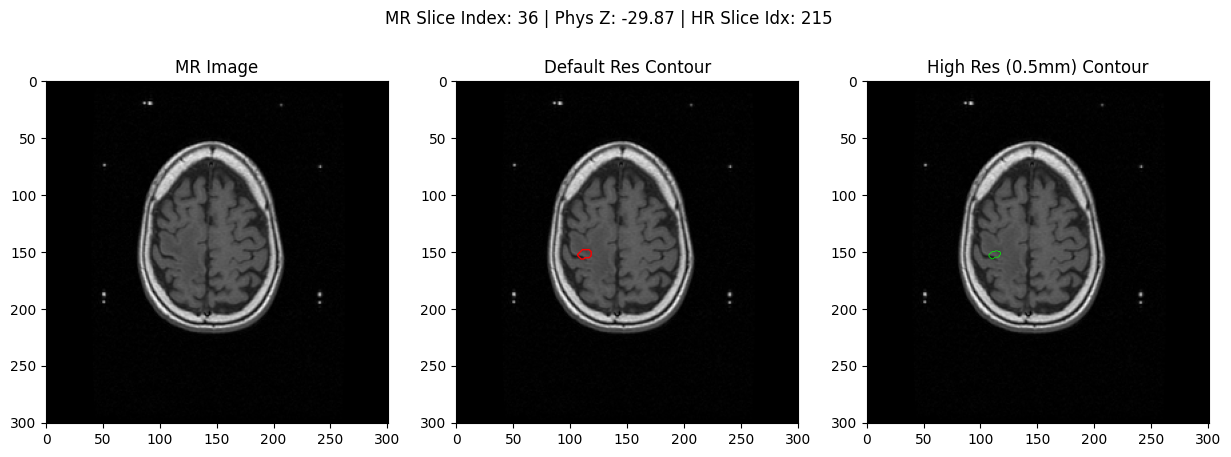

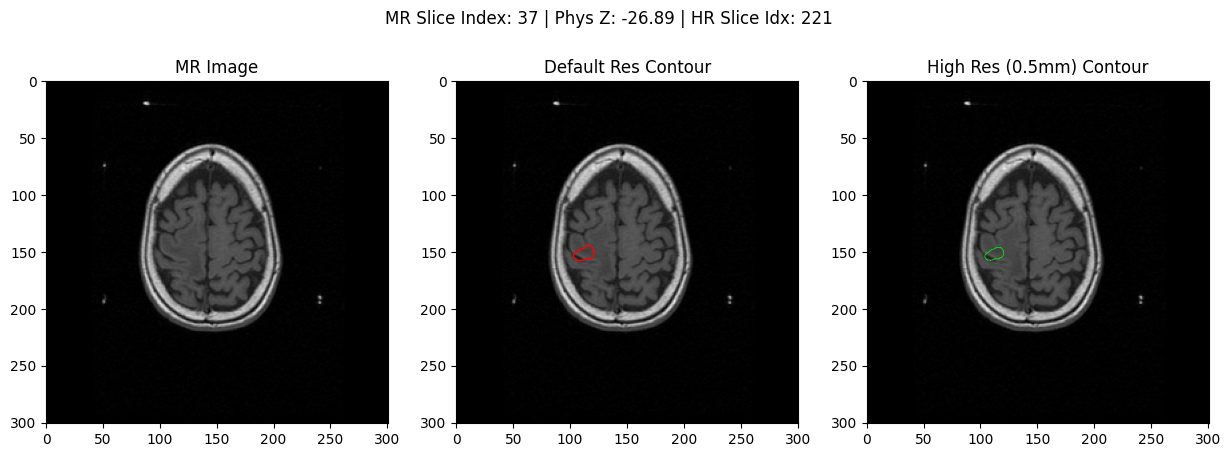

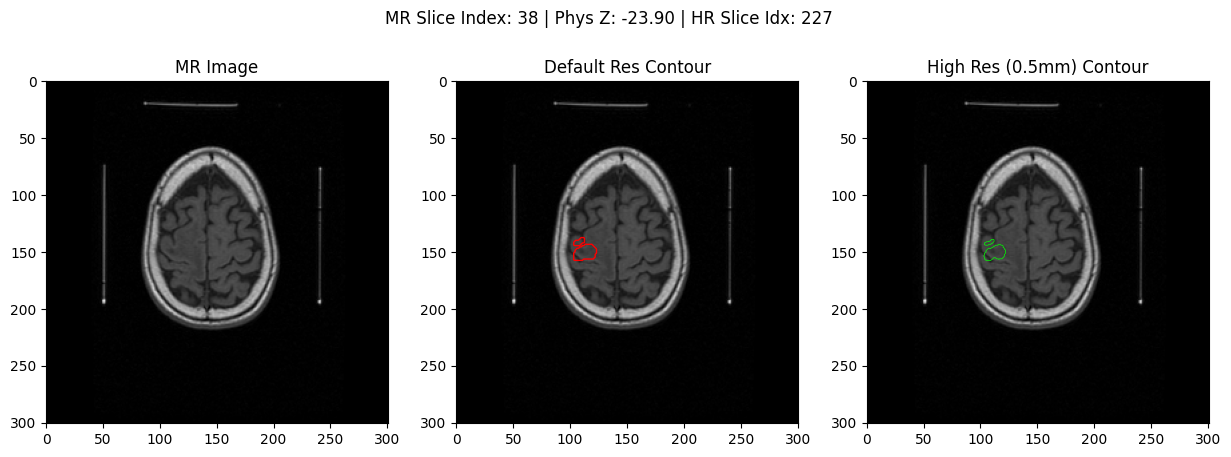

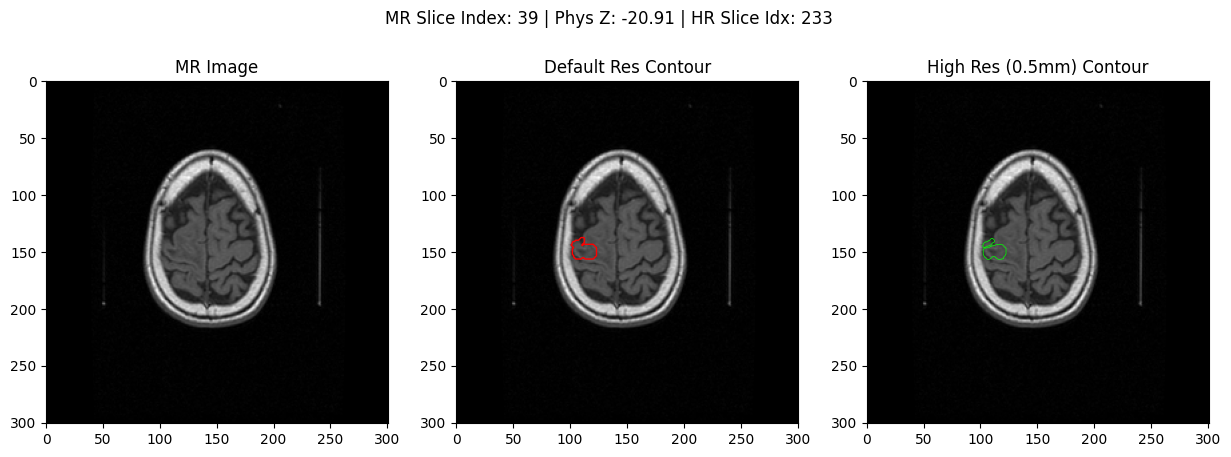

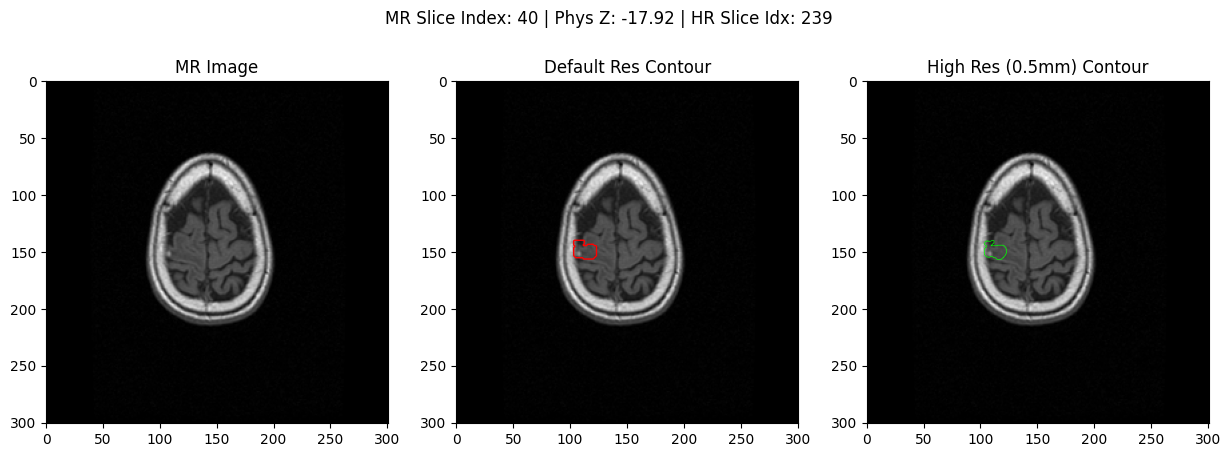

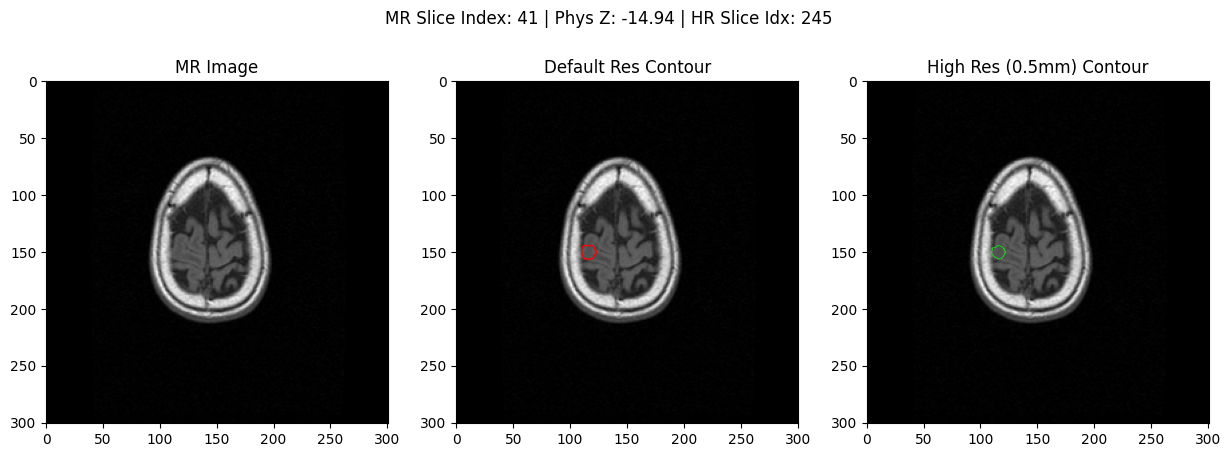

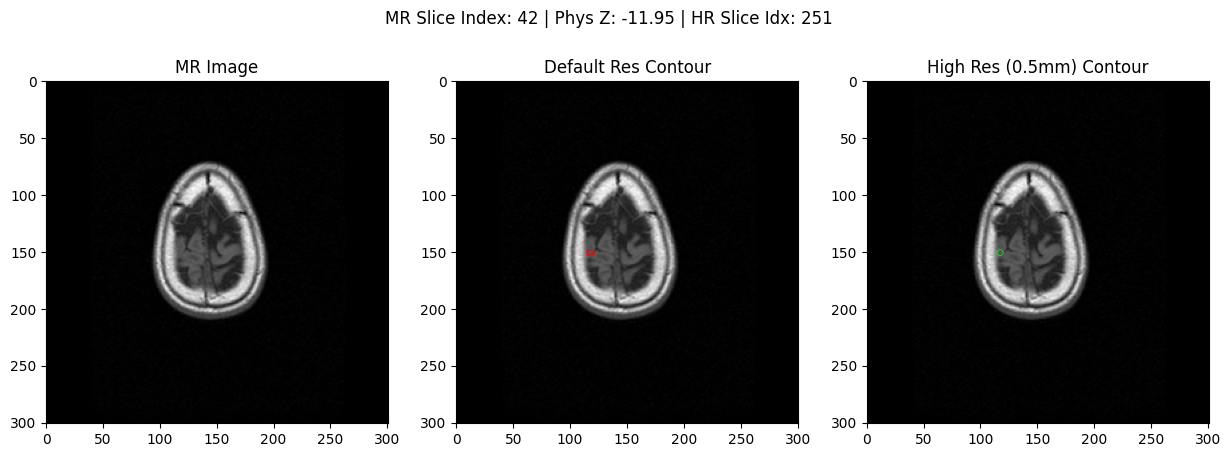

In [17]:
# ==========================================
# 3. Visualization Loop
# ==========================================

# Loop through original MR slices
# We define 'extent' to make the axes align visually in Matplotlib despite different matrix sizes
# Extent = [left, right, bottom, top] in "index space" of the original image roughly
# A simpler way is to assume pixels are square and just map the FOV 0..FOV_mm

fov_x_mm = orig_size[0] * orig_spacing[0]
fov_y_mm = orig_size[1] * orig_spacing[1]
extent_mm = [0, fov_x_mm, fov_y_mm, 0] # Standard image coords (y down)

# Only show slices that have some content in the default mask to save space
slices_with_content = np.where(np.sum(mask_default, axis=(1, 2)) > 0)[0]
if len(slices_with_content) == 0:
    print("No contours found in default mask.")
    check_slices = range(orig_size[2]//2, orig_size[2]//2 + 5) # Fallback to middle slices
else:
    check_slices = slices_with_content

for i in check_slices:
    # A. Get MR Slice
    mr_slice = sitk.GetArrayFromImage(orig_image)[i, :, :]
    
    # B. Get Default Mask Slice
    def_mask_slice = mask_default[i, :, :]
    
    # C. Get Corresponding High-Res Mask Slice
    # 1. Find physical Z of the current MR slice
    #    Note: We use (0,0,i) index to get the origin of that slice in space
    phys_point_slice_origin = orig_image.TransformIndexToPhysicalPoint((0, 0, int(i)))
    
    # 2. Find closest Z index in High-Res Grid
    hr_index_float = ref_img_hr.TransformPhysicalPointToContinuousIndex(phys_point_slice_origin)
    hr_slice_idx = int(np.round(hr_index_float[2]))
    
    if 0 <= hr_slice_idx < mask_hr.shape[0]:
        hr_mask_slice = mask_hr[hr_slice_idx, :, :]
    else:
        hr_mask_slice = np.zeros((mask_hr.shape[1], mask_hr.shape[2]))

    # --- Plotting ---
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"MR Slice Index: {i} | Phys Z: {phys_point_slice_origin[2]:.2f} | HR Slice Idx: {hr_slice_idx}")
    
    # 1. MR Only
    axs[0].imshow(mr_slice, cmap='gray', extent=extent_mm)
    axs[0].set_title("MR Image")
    
    # 2. MR + Default Mask
    axs[1].imshow(mr_slice, cmap='gray', extent=extent_mm)
    axs[1].contour(def_mask_slice, levels=[0.5], colors='red', linewidths=1, extent=extent_mm)
    axs[1].set_title("Default Res Contour")
    
    # 3. MR + High-Res Mask
    axs[2].imshow(mr_slice, cmap='gray', extent=extent_mm)
    # Note: hr_mask_slice has more pixels, but 'extent=extent_mm' scales it to fit the physical FOV
    axs[2].contour(hr_mask_slice, levels=[0.5], colors='lime', linewidths=0.5, extent=extent_mm)
    axs[2].set_title("High Res (0.5mm) Contour")
    
    plt.show()

------------------------------
Generating Sagittal Views (Y-Z Plane)...
------------------------------


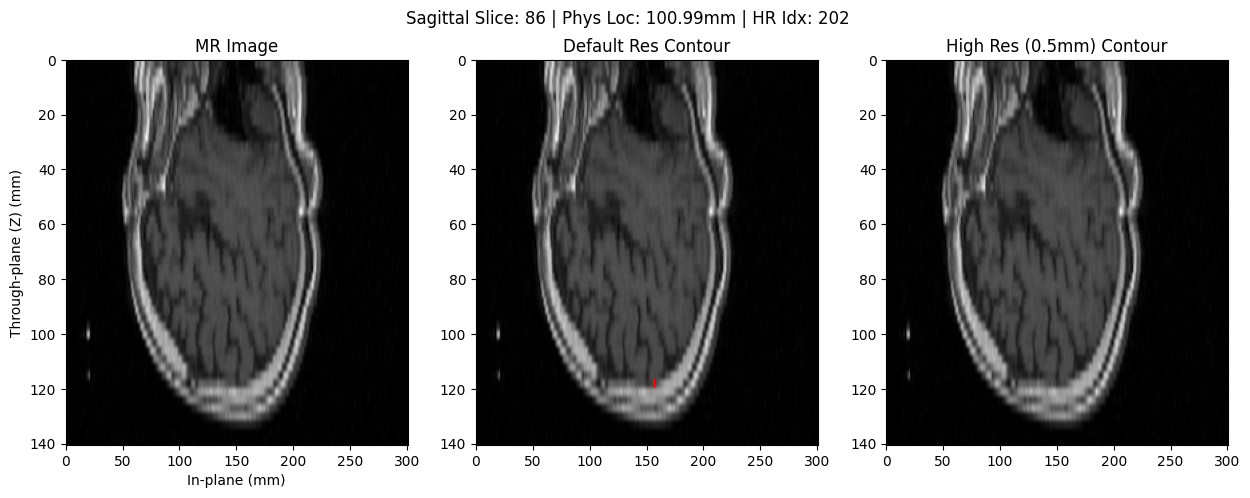

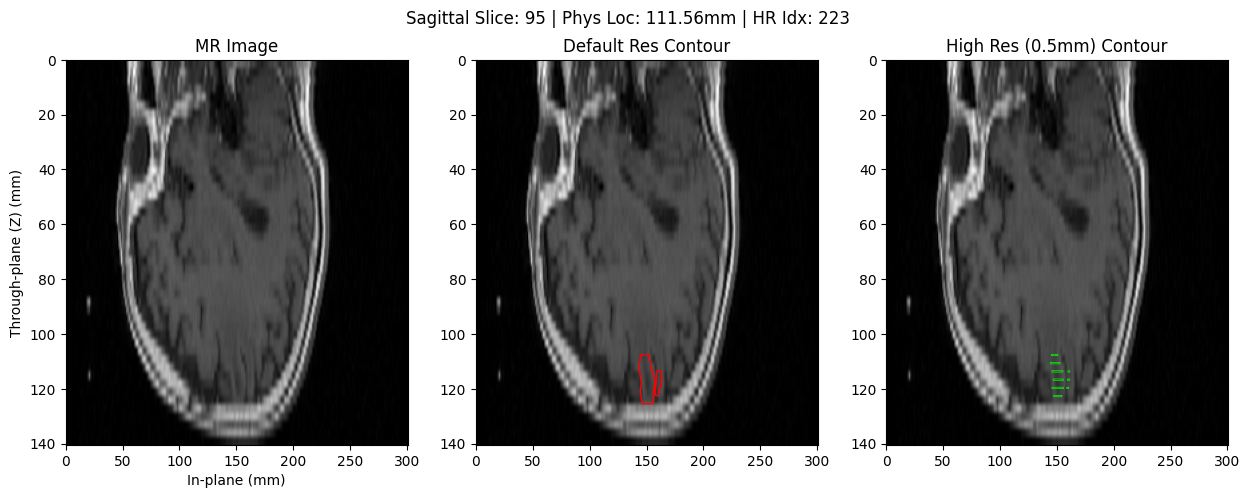

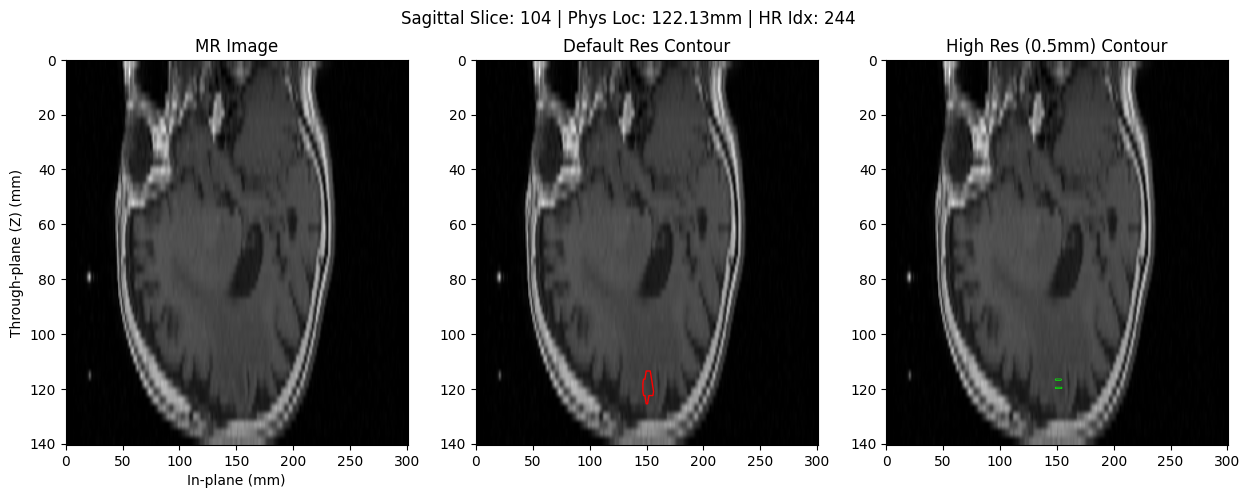

------------------------------
Generating Coronal Views (X-Z Plane)...
------------------------------


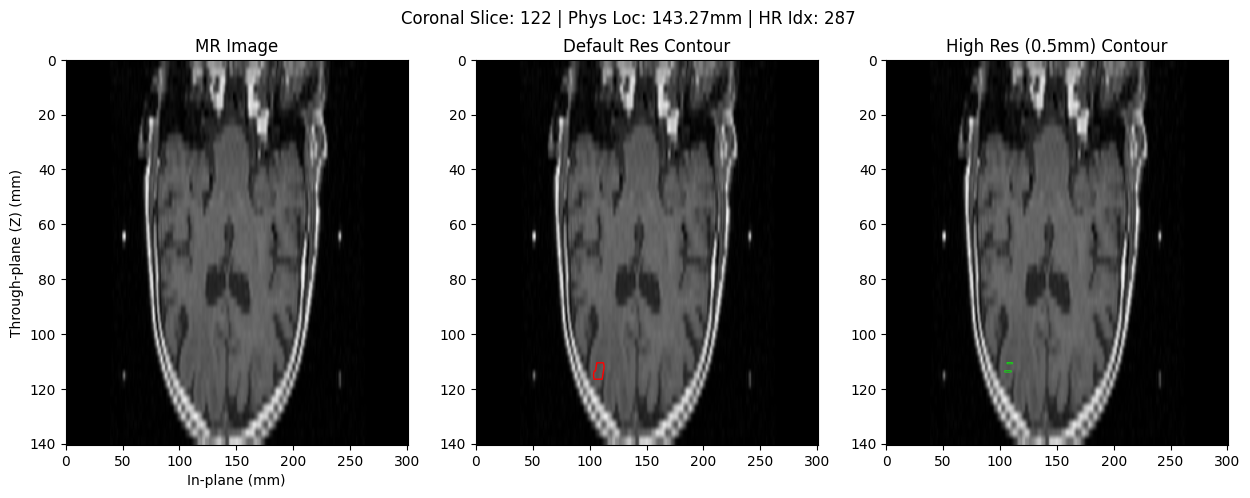

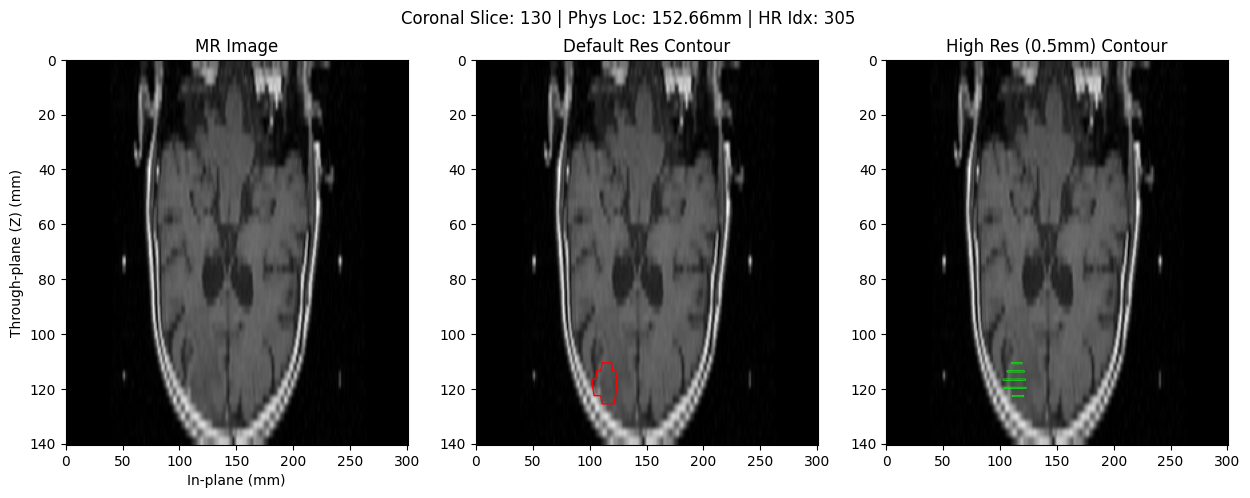

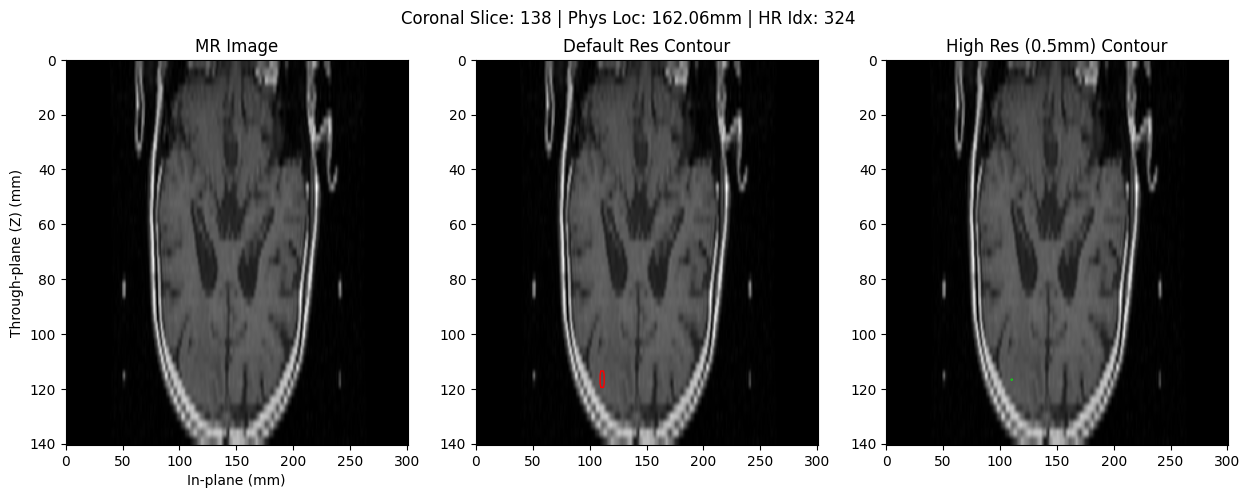

In [18]:
# ==========================================
# 4. Sagittal & Coronal Visualization Setup
# ==========================================

# Calculate FOV for Z axis (Height in these views)
fov_z_mm = orig_size[2] * orig_spacing[2]

# Helper function to display plots
def plot_orthogonal_view(slice_idx, orientation, mr_slice, def_mask_slice, hr_mask_slice, 
                         phys_coord, hr_idx, extent):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"{orientation} Slice: {slice_idx} | Phys Loc: {phys_coord:.2f}mm | HR Idx: {hr_idx}")

    # 1. MR Only
    axs[0].imshow(mr_slice, cmap='gray', aspect='auto', extent=extent, origin='upper')
    axs[0].set_title("MR Image")
    axs[0].set_xlabel("In-plane (mm)")
    axs[0].set_ylabel("Through-plane (Z) (mm)")

    # 2. MR + Default Mask
    axs[1].imshow(mr_slice, cmap='gray', aspect='auto', extent=extent, origin='upper')
    if np.any(def_mask_slice):
        axs[1].contour(def_mask_slice, levels=[0.5], colors='red', linewidths=1, extent=extent, origin='upper')
    axs[1].set_title("Default Res Contour")

    # 3. MR + High-Res Mask
    axs[2].imshow(mr_slice, cmap='gray', aspect='auto', extent=extent, origin='upper')
    if np.any(hr_mask_slice):
        axs[2].contour(hr_mask_slice, levels=[0.5], colors='lime', linewidths=0.5, extent=extent, origin='upper')
    axs[2].set_title("High Res (0.5mm) Contour")
    
    plt.show()

# ==========================================
# 5. Sagittal View (Side View) - Slicing X axis
# ==========================================
print("-" * 30)
print("Generating Sagittal Views (Y-Z Plane)...")
print("-" * 30)

# Sagittal view means slicing along X (index 2 in SimpleITK nomenclature (x,y,z), index 2 in Numpy (z,y,x))
# Image Array shape is (Z, Y, X). So we slice [:, :, i]
# Resulting image axes: Vertical = Z, Horizontal = Y

# Extent: [Left, Right, Bottom, Top] -> [0, Y_FOV, Z_FOV, 0] (Origin Upper)
sag_extent = [0, fov_y_mm, fov_z_mm, 0]

# Find slices with content along X axis
# Sum over Z (axis 0) and Y (axis 1)
sag_content_indices = np.where(np.sum(mask_default, axis=(0, 1)) > 0)[0]

if len(sag_content_indices) == 0:
    sag_check_slices = [orig_size[0] // 2] # Middle X slice
else:
    # Pick 3 representative slices (start, middle, end of structure)
    mid = len(sag_content_indices) // 2
    sag_check_slices = [sag_content_indices[0], sag_content_indices[mid], sag_content_indices[-1]]
    # Limit to unique values if structure is small
    sag_check_slices = sorted(list(set(sag_check_slices)))

for i in sag_check_slices:
    # A. Get Data Slices
    # Numpy shape (Z, Y, X) -> slice X gives (Z, Y)
    mr_slice = sitk.GetArrayFromImage(orig_image)[:, :, i]
    def_mask_slice = mask_default[:, :, i]
    
    # B. Coordinate Mapping
    # Point in physical space corresponding to X-slice 'i' (y=0, z=0 just for plane alignment)
    phys_point = orig_image.TransformIndexToPhysicalPoint((int(i), 0, 0))
    
    # Transform this physical X-coordinate to High-Res Index Space
    hr_idx_float = ref_img_hr.TransformPhysicalPointToContinuousIndex(phys_point)
    hr_slice_idx = int(np.round(hr_idx_float[0])) # Index 0 is X
    
    # C. Get High-Res Slice
    # HR shape is (Z, Y, X). We slice X.
    if 0 <= hr_slice_idx < mask_hr.shape[2]:
        hr_mask_slice = mask_hr[:, :, hr_slice_idx]
    else:
        hr_mask_slice = np.zeros((mask_hr.shape[0], mask_hr.shape[1]))

    # D. Plot
    plot_orthogonal_view(i, "Sagittal", mr_slice, def_mask_slice, hr_mask_slice, 
                         phys_point[0], hr_slice_idx, sag_extent)


# ==========================================
# 6. Coronal View (Front View) - Slicing Y axis
# ==========================================
print("-" * 30)
print("Generating Coronal Views (X-Z Plane)...")
print("-" * 30)

# Coronal view means slicing along Y (index 1 in SimpleITK, index 1 in Numpy (z,y,x))
# Image Array shape is (Z, Y, X). So we slice [:, j, :]
# Resulting image axes: Vertical = Z, Horizontal = X

# Extent: [Left, Right, Bottom, Top] -> [0, X_FOV, Z_FOV, 0]
cor_extent = [0, fov_x_mm, fov_z_mm, 0]

# Find slices with content along Y axis
# Sum over Z (axis 0) and X (axis 2)
cor_content_indices = np.where(np.sum(mask_default, axis=(0, 2)) > 0)[0]

if len(cor_content_indices) == 0:
    cor_check_slices = [orig_size[1] // 2] # Middle Y slice
else:
    mid = len(cor_content_indices) // 2
    cor_check_slices = [cor_content_indices[0], cor_content_indices[mid], cor_content_indices[-1]]
    cor_check_slices = sorted(list(set(cor_check_slices)))

for j in cor_check_slices:
    # A. Get Data Slices
    # Numpy shape (Z, Y, X) -> slice Y gives (Z, X)
    mr_slice = sitk.GetArrayFromImage(orig_image)[:, j, :]
    def_mask_slice = mask_default[:, j, :]
    
    # B. Coordinate Mapping
    # Point in physical space corresponding to Y-slice 'j'
    phys_point = orig_image.TransformIndexToPhysicalPoint((0, int(j), 0))
    
    # Transform this physical Y-coordinate to High-Res Index Space
    hr_idx_float = ref_img_hr.TransformPhysicalPointToContinuousIndex(phys_point)
    hr_slice_idx = int(np.round(hr_idx_float[1])) # Index 1 is Y
    
    # C. Get High-Res Slice
    # HR shape is (Z, Y, X). We slice Y.
    if 0 <= hr_slice_idx < mask_hr.shape[1]:
        hr_mask_slice = mask_hr[:, hr_slice_idx, :]
    else:
        hr_mask_slice = np.zeros((mask_hr.shape[0], mask_hr.shape[2]))

    # D. Plot
    plot_orthogonal_view(j, "Coronal", mr_slice, def_mask_slice, hr_mask_slice, 
                         phys_point[1], hr_slice_idx, cor_extent)